<a href="https://colab.research.google.com/github/crediblebilal/ML-Google-Colab-Notebooks/blob/main/transfer_learning_flower_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tensorflow Tutorial Link: https://www.tensorflow.org/tutorials/images/transfer_learning

Image CLassifiacation Using Transfer Learning

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 2s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [5]:
batch_size = 32
img_height = 160
img_width = 160

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [9]:
# AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
val_batches = tf.data.experimental.cardinality(val_ds)

In [11]:
print(val_batches)

tf.Tensor(23, shape=(), dtype=int64)


In [12]:
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)

In [13]:
# train == train_ds
# validation == validation_dataset
# test == test_dataset

In [14]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 19
Number of test batches: 4


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'> 32
<class 'tensorflow.python.framework.ops.EagerTensor'> 32
<class 'tensorflow.python.framework.ops.EagerTensor'> 32
<class 'tensorflow.python.framework.ops.EagerTensor'> 32
<class 'tensorflow.python.framework.ops.EagerTensor'> 32
<class 'tensorflow.python.framework.ops.EagerTensor'> 32


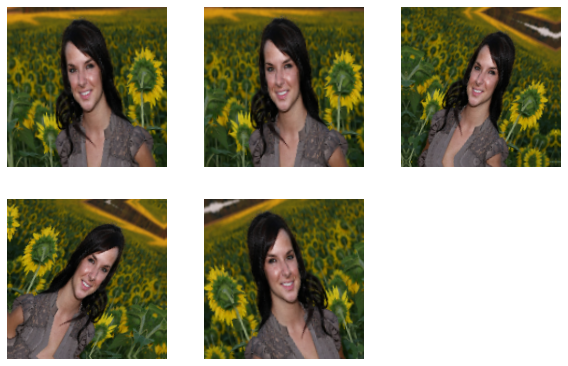

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    print(type(images),type(images[0]), len(images))
    for i in range(5):
        augmented_images = data_augmentation(images)
        print(type(augmented_images), len(augmented_images))
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [18]:
IMG_SIZE = (160, 160)

In [19]:
IMG_SHAPE = IMG_SIZE + (3,)

In [20]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape= IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [21]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [22]:
base_model.trainable = False

In [23]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [24]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [25]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [26]:
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [27]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [28]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [30]:
len(model.trainable_variables)

2

In [31]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

19/19 [==============================] - 12s 490ms/step - loss: 2.1200 - accuracy: 0.1848


In [32]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.12
initial accuracy: 0.18


In [33]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
92/92 [==============================] - 64s 658ms/step - loss: 1.8364 - accuracy: 0.2585 - val_loss: 1.3928 - val_accuracy: 0.4290
Epoch 2/10
92/92 [==============================] - 58s 636ms/step - loss: 1.3275 - accuracy: 0.4789 - val_loss: 1.0602 - val_accuracy: 0.5858
Epoch 3/10
92/92 [==============================] - 58s 636ms/step - loss: 1.0702 - accuracy: 0.5903 - val_loss: 0.8763 - val_accuracy: 0.6700
Epoch 4/10
92/92 [==============================] - 59s 637ms/step - loss: 0.9041 - accuracy: 0.6676 - val_loss: 0.7620 - val_accuracy: 0.7211
Epoch 5/10
92/92 [==============================] - 59s 638ms/step - loss: 0.7870 - accuracy: 0.7105 - val_loss: 0.6784 - val_accuracy: 0.7640
Epoch 6/10
92/92 [==============================] - 59s 638ms/step - loss: 0.7118 - accuracy: 0.7520 - val_loss: 0.6241 - val_accuracy: 0.7904
Epoch 7/10
92/92 [==============================] - 58s 634ms/step - loss: 0.6838 - accuracy: 0.7537 - val_loss: 0.5744 - val_accuracy: 0.8069

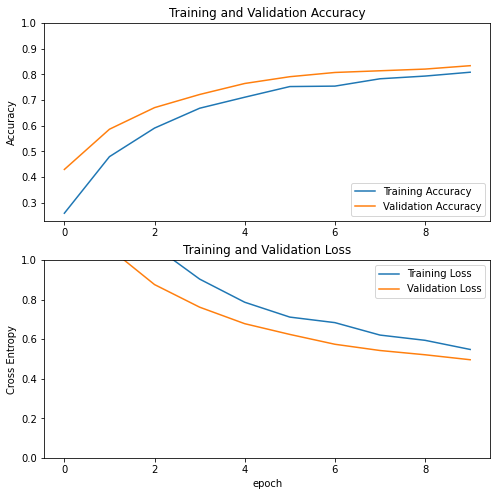

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
base_model.trainable = True

In [36]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [37]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [38]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [39]:
len(model.trainable_variables)

56

In [40]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
92/92 [==============================] - 106s 1s/step - loss: 0.4696 - accuracy: 0.8321 - val_loss: 0.3642 - val_accuracy: 0.8729
Epoch 11/20
92/92 [==============================] - 102s 1s/step - loss: 0.3750 - accuracy: 0.8627 - val_loss: 0.3299 - val_accuracy: 0.8845
Epoch 12/20
92/92 [==============================] - 99s 1s/step - loss: 0.3457 - accuracy: 0.8719 - val_loss: 0.3199 - val_accuracy: 0.8713
Epoch 13/20
92/92 [==============================] - 96s 1s/step - loss: 0.3042 - accuracy: 0.8873 - val_loss: 0.2868 - val_accuracy: 0.9059
Epoch 14/20
92/92 [==============================] - 95s 1s/step - loss: 0.2677 - accuracy: 0.9005 - val_loss: 0.2818 - val_accuracy: 0.8960
Epoch 15/20
92/92 [==============================] - 94s 1s/step - loss: 0.2371 - accuracy: 0.9104 - val_loss: 0.2823 - val_accuracy: 0.8960
Epoch 16/20
92/92 [==============================] - 95s 1s/step - loss: 0.2209 - accuracy: 0.9166 - val_loss: 0.2459 - val_accuracy: 0.9076
Epoch 17/20

In [41]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

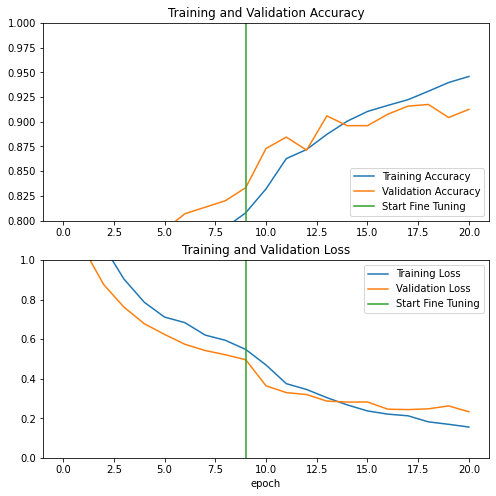

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 2s 486ms/step - loss: 0.3612 - accuracy: 0.8750
Test accuracy : 0.875


In [59]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

In [60]:
print(type(predictions), predictions.shape)

<class 'numpy.ndarray'> (32, 5)


In [61]:
print(type(image_batch), image_batch.shape, type(label_batch), label_batch.shape)

<class 'numpy.ndarray'> (32, 160, 160, 3) <class 'numpy.ndarray'> (32,)


In [62]:
print(predictions)

[[ -3.6826985   -2.1582522   -8.59815      6.52702     -8.244773  ]
 [ -1.7635401   -5.8529963   -0.09819224  -3.390801    -0.11638242]
 [ -5.380422    -6.621283    -0.21257313  -4.942393     4.1822968 ]
 [ -8.8122835   -2.0775204   -6.1326385    6.8582015   -3.9806552 ]
 [ -3.2146378    6.768828    -7.0562153    0.18418404  -8.882383  ]
 [  4.746421    -2.242175    -6.473401    -3.076399    -5.9047537 ]
 [-10.549721    -5.242391    -6.499498     6.4647746   -1.6142879 ]
 [ -6.148318    -8.407277     3.8663425   -4.0668435    4.878354  ]
 [ -6.2632947   -1.6141694   -1.8370876   -3.3830547   -3.7878954 ]
 [ -5.7584715   -1.5197512   -3.9583464    1.2700155   -0.8745245 ]
 [ -4.261777    -4.3951225   -1.8023648   -0.7406243   -1.2232473 ]
 [ -4.667412    -4.266346    -7.291569     6.76363     -5.92159   ]
 [ -3.0294669   -3.3293738    0.74715245  -1.4890889    1.410631  ]
 [ -0.39559567   8.140893    -4.3973827   -6.522048    -6.287865  ]
 [ -2.395146   -11.211981     8.543713    -7.376

In [63]:
print(label_batch)

[3 2 4 3 1 0 3 4 2 3 1 3 0 1 2 2 4 3 0 0 2 3 3 3 1 3 1 2 0 1 4 1]


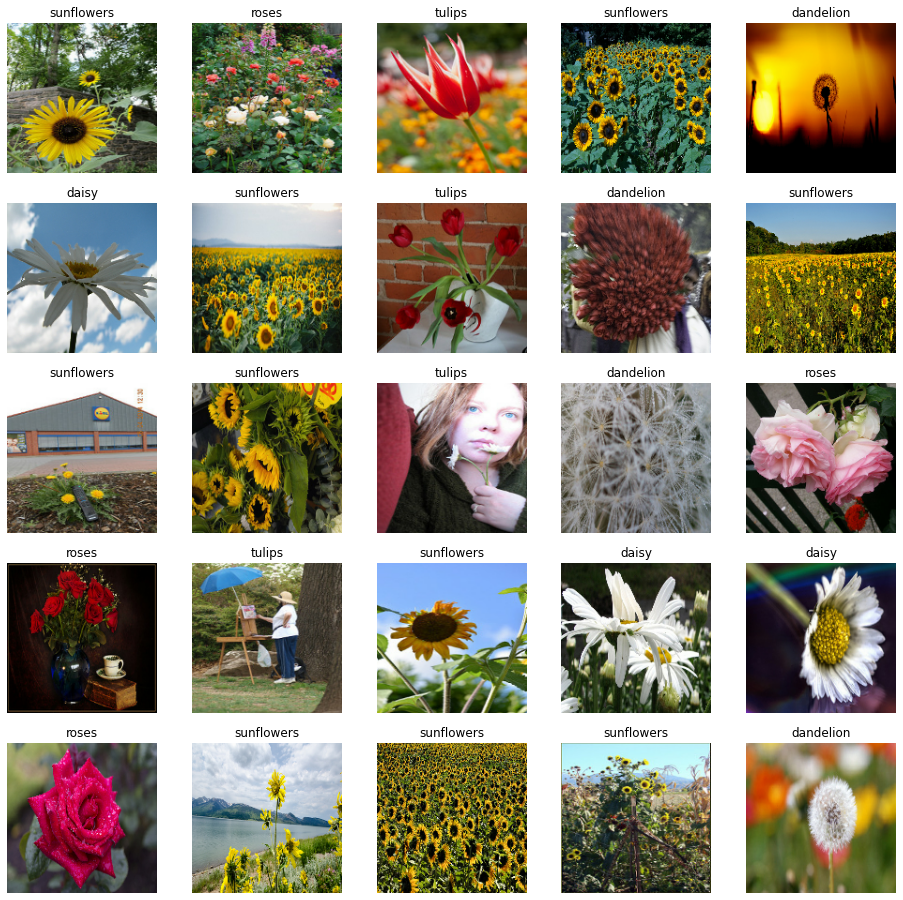

In [69]:
plt.figure(figsize=(16, 16))
for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[np.argmax(predictions[i])])
  plt.axis("off")

In [71]:
model.save('my_model_cnn_TL_flower')

INFO:tensorflow:Assets written to: my_model_cnn_TL_flower/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [72]:
my_model_loaded = tf.keras.models.load_model('my_model_cnn_TL_flower') #load model

In [73]:
my_model_loaded.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     